In [52]:
import gzip
import json
from typing import Iterator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Table of Contents

- [Step D.1](#Step-D.1)
- [Step D.2](#Step-D.2)
- [Step D.3](#Step-D.3)
- [Step D.4](#Step-D.4)
- [Step D.5](#Step-D.5)
- [Step D.6](#Step-D.6)

In [2]:
# download the “small” 5-core dataset for the category "Digital Music"
# dataset source: https://nijianmo.github.io/amazon/index.html

!wget --backups=1 http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz -P data/

--2022-02-27 15:02:20--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19408584 (19M) [application/octet-stream]
Saving to: ‘data/Digital_Music_5.json.gz’

Digital_Music_5.jso 100%[===================>]  18.51M  77.0KB/s    in 4m 17s  

2022-02-27 15:06:37 (73.7 KB/s) - ‘data/Digital_Music_5.json.gz’ saved [19408584/19408584]



## Step D.1

In [30]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [31]:
def parse(filepath: str) -> Iterator[dict]:
    file_obj = gzip.open(filepath, "rb")
    for line in file_obj:
        yield json.loads(line)

In [32]:
def file_to_dataframe(filepath: str) -> pd.DataFrame:
    i = 0
    df = {}
    for d in parse(filepath):
        df[i] = {
            "user": d["reviewerID"],
            "item": d["asin"],
            "rating": d["overall"],
        }  # keep only the essential data
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")

In [33]:
review_data = file_to_dataframe("data/Digital_Music_5.json.gz")

inspect_df(review_data)

shape: (169781, 3)


,user,item,rating
0,A2TYZ821XXK2YZ,3426958910,5.0
1,A3OFSREZADFUDY,3426958910,5.0
2,A2VAMODP8M77NG,3426958910,5.0
3,AAKSLZ9IDTEH0,3426958910,4.0
4,A3OH43OZJLKI09,5557706259,5.0


In [34]:
review_data["user"] = review_data.groupby("user").ngroup()

In [35]:
review_data["item"] = review_data.groupby("item").ngroup()

In [36]:
n_users = len(review_data["user"].unique())

user_vector = np.asarray(review_data["user"].astype(np.int32))

In [37]:
n_items = len(review_data["item"].unique())

item_vector = np.asarray(review_data["item"].astype(np.int32))

In [38]:
n_users

16566

In [39]:
n_items

11797

In [40]:
latent_factors = 80

In [41]:
X = np.array([user_vector, item_vector]).T
y = review_data["rating"].values

In [42]:
X.shape

(169781, 2)

In [43]:
y.shape

(169781,)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Step D.2

In [45]:
tf.keras.backend.clear_session()

In [46]:
def dmf_neural_network(
    users_vec: np.array,
    items_vec: np.array,
    n_users: int,
    n_item: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    users_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="users_input")
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(users_input)
    u = tf.keras.layers.Flatten()(u)

    items_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="items_input")
    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(items_input)
    i = tf.keras.layers.Flatten()(i)

    x = tf.keras.layers.Concatenate(name="concatenated_vector")([i, u])

    for n in [1, 2, 4]:

        x = tf.keras.layers.Dense(
            units=200 / n,
            activation="elu",
            kernel_initializer="glorot_normal",
        )(x)
        x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(
        units=12, activation="elu", kernel_initializer="glorot_normal"
    )(x)

    output = tf.keras.layers.Dense(units=1)(x)

    return tf.keras.Model(inputs=[users_input, items_input], outputs=output)

## Step D.3

In [47]:
model = dmf_neural_network(
    users_vec=user_vector,
    items_vec=item_vector,
    n_users=n_users,
    n_item=n_items,
    n_latent_factors=latent_factors,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 items_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 users_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 items_embedding (Embedding)    (None, 1, 80)        943840      ['items_input[0][0]']            
                                                                                                  
 users_embedding (Embedding)    (None, 1, 80)        1325360     ['users_input[0][0]']            
                                                                                              

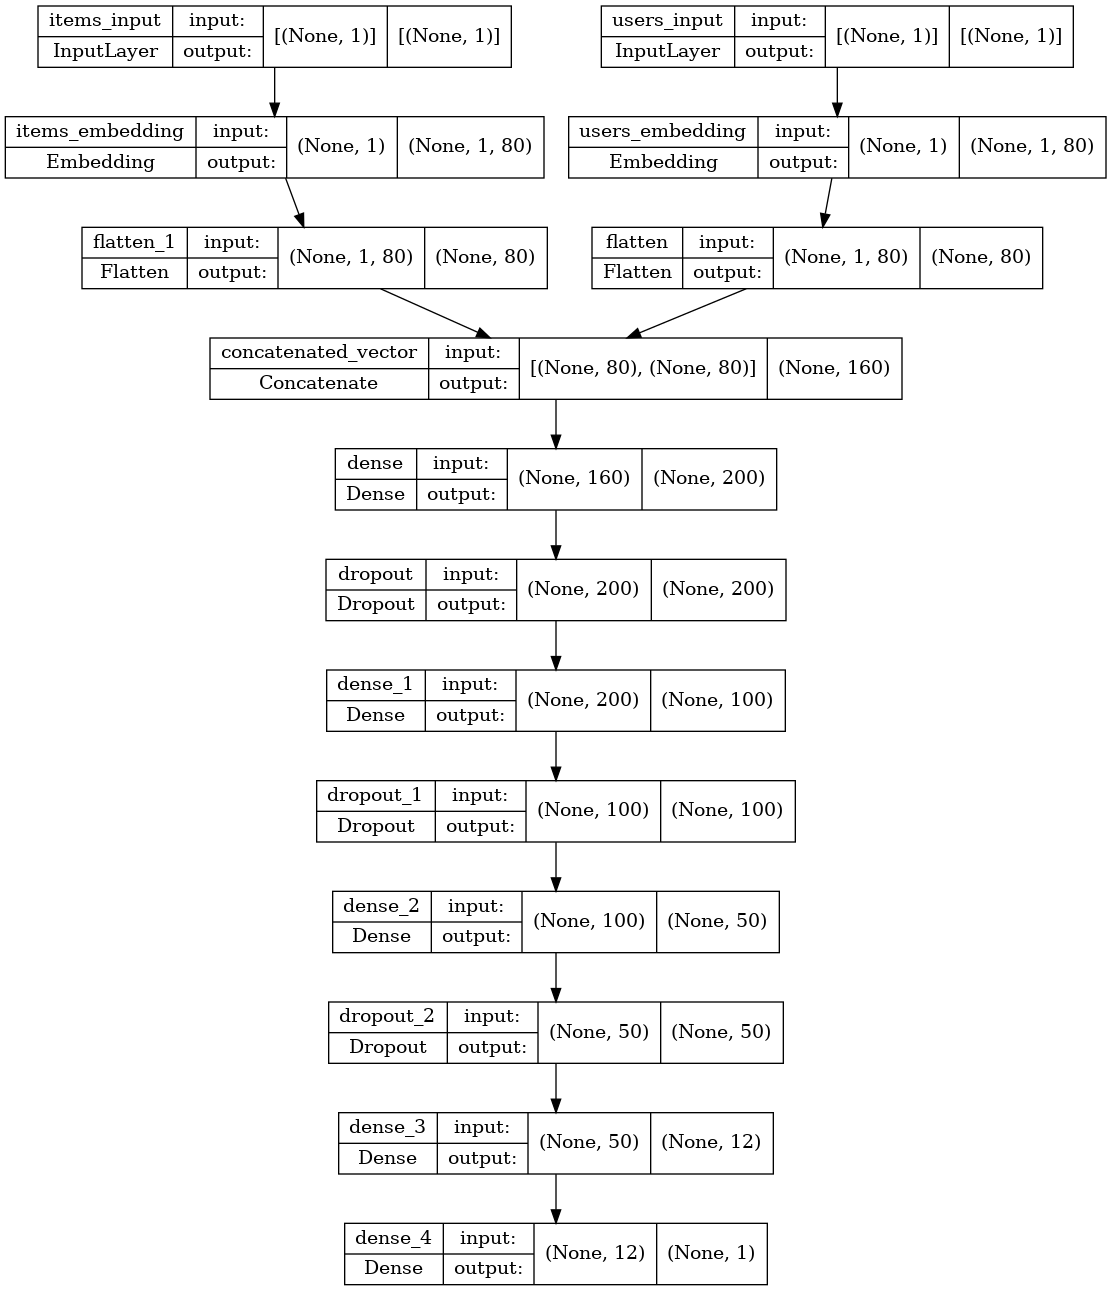

In [48]:
tf.keras.utils.plot_model(
    model, to_file="DMF_model.png", show_shapes=True, show_layer_names=True
)

In [49]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=40, restore_best_weights=True
)

In [50]:
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    epochs=100,
    validation_split=0.1,
    batch_size=256,
    callbacks=[callback],
)

Epoch 1/100
478/478 [==============================] - 11s 23ms/step - loss: 1.1572 - root_mean_squared_error: 1.0757 - val_loss: 0.3500 - val_root_mean_squared_error: 0.5916
Epoch 2/100
478/478 [==============================] - 10s 22ms/step - loss: 0.3629 - root_mean_squared_error: 0.6024 - val_loss: 0.3318 - val_root_mean_squared_error: 0.5760
Epoch 3/100
478/478 [==============================] - 11s 23ms/step - loss: 0.3035 - root_mean_squared_error: 0.5509 - val_loss: 0.3244 - val_root_mean_squared_error: 0.5696
Epoch 4/100
478/478 [==============================] - 11s 22ms/step - loss: 0.2709 - root_mean_squared_error: 0.5205 - val_loss: 0.3325 - val_root_mean_squared_error: 0.5767
Epoch 5/100
478/478 [==============================] - 10s 22ms/step - loss: 0.2438 - root_mean_squared_error: 0.4937 - val_loss: 0.3276 - val_root_mean_squared_error: 0.5723
Epoch 6/100
478/478 [==============================] - 11s 22ms/step - loss: 0.2248 - root_mean_squared_error: 0.4742 - val_l

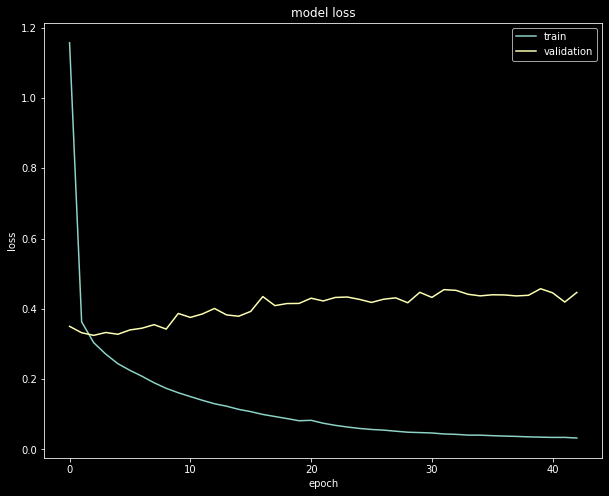

In [62]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [55]:
evaluation = model.evaluate(x=[X_test[:, 0], X_test[:, 1]], y=y_test, verbose=1)

1062/1062 [==============================] - 1s 723us/step - loss: 0.3239 - root_mean_squared_error: 0.5691


In [59]:
mse, rmse = evaluation

print("test MSE  = " + str(mse))
print("test RMSE = " + str(rmse))

test MSE  = 0.32389184832572937
test RMSE = 0.5691149830818176


## Step D.4

## Step D.5

## Step D.6